<a href="https://colab.research.google.com/github/ratel0307/Deep-Learning/blob/main/6%EC%9E%A5_%ED%95%99%EC%8A%B5_%EA%B4%80%EB%A0%A8_%EA%B8%B0%EC%88%A0%EB%93%A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
class SGD:
  def __init__(self, lr=0.01):
    self.lr = lr

  def update(self, params, grads):
    for key in params.keys():
      params[key] -= self.lr * grads[key]

In [ ]:
# 모멘텀

import numpy as np

class Momentum:
  def __init__(self, lr=0.01, momentum=0.9):
    self.lr = lr
    self.momentum = momentum
    self.v = None

  def update(self, params, grads):
    if self.v is None:
      self.v = {}
      for key, val in params.items():
        self.v[key] = np.zeros_like(val)

    for key in params.keys():
      self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
      params[key] += self.v[key]


In [ ]:
# AdaGrad

class AdaGrad:
  def __init__(self, lr=0.01):
    self.lr = lr
    self.h = None

  def update(self, params, grads):
    if self.h is None:
      self.h = {}
      for key, val in params.items():
        self.h[key] = np.zeros_like(val)

    for key in params.keys():
      self.h[key] += grads[key] * grads[key]
      params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)



In [ ]:
# 필요한 것들 미리 실행

import numpy as np


def smooth_curve(x):
    """손실 함수의 그래프를 매끄럽게 하기 위해 사용

    참고：http://glowingpython.blogspot.jp/2012/02/convolution-with-numpy.html
    """
    window_len = 11
    s = np.r_[x[window_len-1:0:-1], x, x[-1:-window_len:-1]]
    w = np.kaiser(window_len, 2)
    y = np.convolve(w/w.sum(), s, mode='valid')
    return y[5:len(y)-5]


def shuffle_dataset(x, t):
    """데이터셋을 뒤섞는다.

    Parameters
    ----------
    x : 훈련 데이터
    t : 정답 레이블

    Returns
    -------
    x, t : 뒤섞은 훈련 데이터와 정답 레이블
    """
    permutation = np.random.permutation(x.shape[0])
    x = x[permutation,:] if x.ndim == 2 else x[permutation,:,:,:]
    t = t[permutation]

    return x, t

def conv_output_size(input_size, filter_size, stride=1, pad=0):
    return (input_size + 2*pad - filter_size) / stride + 1


def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """다수의 이미지를 입력받아 2차원 배열로 변환한다(평탄화).

    Parameters
    ----------
    input_data : 4차원 배열 형태의 입력 데이터(이미지 수, 채널 수, 높이, 너비)
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩

    Returns
    -------
    col : 2차원 배열
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col


def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """(im2col과 반대) 2차원 배열을 입력받아 다수의 이미지 묶음으로 변환한다.

    Parameters
    ----------
    col : 2차원 배열(입력 데이터)
    input_shape : 원래 이미지 데이터의 형상（예：(10, 1, 28, 28)）
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩

    Returns
    -------
    img : 변환된 이미지들
    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

In [ ]:
# coding: utf-8
import numpy as np


def identity_function(x):
    return x


def step_function(x):
    return np.array(x > 0, dtype=np.int)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)


def relu(x):
    return np.maximum(0, x)


def relu_grad(x):
    grad = np.zeros(x)
    grad[x>=0] = 1
    return grad


def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))


def mean_squared_error(y, t):
    return 0.5 * np.sum((y-t)**2)


def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)

    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


def softmax_loss(X, t):
    y = softmax(X)
    return cross_entropy_error(y, t)

In [ ]:
# coding: utf-8
import numpy as np


class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx


class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = sigmoid(x)
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx


class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b

        self.x = None
        self.original_x_shape = None
        # 가중치와 편향 매개변수의 미분
        self.dW = None
        self.db = None

    def forward(self, x):
        # 텐서 대응
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)

        dx = dx.reshape(*self.original_x_shape)  # 입력 데이터 모양 변경(텐서 대응)
        return dx


class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 손실함수
        self.y = None    # softmax의 출력
        self.t = None    # 정답 레이블(원-핫 인코딩 형태)

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)

        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 정답 레이블이 원-핫 인코딩 형태일 때
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size

        return dx


class Dropout:
    """
    http://arxiv.org/abs/1207.0580
    """
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask


class BatchNormalization:
    """
    http://arxiv.org/abs/1502.03167
    """
    def __init__(self, gamma, beta, momentum=0.9, running_mean=None, running_var=None):
        self.gamma = gamma
        self.beta = beta
        self.momentum = momentum
        self.input_shape = None # 합성곱 계층은 4차원, 완전연결 계층은 2차원

        # 시험할 때 사용할 평균과 분산
        self.running_mean = running_mean
        self.running_var = running_var

        # backward 시에 사용할 중간 데이터
        self.batch_size = None
        self.xc = None
        self.std = None
        self.dgamma = None
        self.dbeta = None

    def forward(self, x, train_flg=True):
        self.input_shape = x.shape
        if x.ndim != 2:
            N, C, H, W = x.shape
            x = x.reshape(N, -1)

        out = self.__forward(x, train_flg)

        return out.reshape(*self.input_shape)

    def __forward(self, x, train_flg):
        if self.running_mean is None:
            N, D = x.shape
            self.running_mean = np.zeros(D)
            self.running_var = np.zeros(D)

        if train_flg:
            mu = x.mean(axis=0)
            xc = x - mu
            var = np.mean(xc**2, axis=0)
            std = np.sqrt(var + 10e-7)
            xn = xc / std

            self.batch_size = x.shape[0]
            self.xc = xc
            self.xn = xn
            self.std = std
            self.running_mean = self.momentum * self.running_mean + (1-self.momentum) * mu
            self.running_var = self.momentum * self.running_var + (1-self.momentum) * var
        else:
            xc = x - self.running_mean
            xn = xc / ((np.sqrt(self.running_var + 10e-7)))

        out = self.gamma * xn + self.beta
        return out

    def backward(self, dout):
        if dout.ndim != 2:
            N, C, H, W = dout.shape
            dout = dout.reshape(N, -1)

        dx = self.__backward(dout)

        dx = dx.reshape(*self.input_shape)
        return dx

    def __backward(self, dout):
        dbeta = dout.sum(axis=0)
        dgamma = np.sum(self.xn * dout, axis=0)
        dxn = self.gamma * dout
        dxc = dxn / self.std
        dstd = -np.sum((dxn * self.xc) / (self.std * self.std), axis=0)
        dvar = 0.5 * dstd / self.std
        dxc += (2.0 / self.batch_size) * self.xc * dvar
        dmu = np.sum(dxc, axis=0)
        dx = dxc - dmu / self.batch_size

        self.dgamma = dgamma
        self.dbeta = dbeta

        return dx


class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad

        # 중간 데이터（backward 시 사용）
        self.x = None
        self.col = None
        self.col_W = None

        # 가중치와 편향 매개변수의 기울기
        self.dW = None
        self.db = None

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T

        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx


class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad

        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)

        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,))

        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)

        return dx

In [ ]:
# coding: utf-8
import numpy as np

def _numerical_gradient_1d(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)

    for idx in range(x.size):
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)

        x[idx] = tmp_val - h
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)

        x[idx] = tmp_val # 값 복원

    return grad


def numerical_gradient_2d(f, X):
    if X.ndim == 1:
        return _numerical_gradient_1d(f, X)
    else:
        grad = np.zeros_like(X)

        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_1d(f, x)

        return grad


def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)

    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)

        x[idx] = tmp_val - h
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)

        x[idx] = tmp_val # 값 복원
        it.iternext()

    return grad

In [ ]:
from collections import OrderedDict

class MultiLayerNet:
    """완전연결 다층 신경망

    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    weight_decay_lambda : 가중치 감소(L2 법칙)의 세기
    """
    def __init__(self, input_size, hidden_size_list, output_size,
                 activation='relu', weight_init_std='relu', weight_decay_lambda=0):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.weight_decay_lambda = weight_decay_lambda
        self.params = {}

        # 가중치 초기화
        self.__init_weight(weight_init_std)

        # 계층 생성
        activation_layer = {'sigmoid': Sigmoid, 'relu': Relu}
        self.layers = OrderedDict()
        for idx in range(1, self.hidden_layer_num+1):
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
                                                      self.params['b' + str(idx)])
            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()

        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
            self.params['b' + str(idx)])

        self.last_layer = SoftmaxWithLoss()

    def __init_weight(self, weight_init_std):
        """가중치 초기화

        Parameters
        ----------
        weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
            'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
            'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
        """
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])  # ReLU를 사용할 때의 권장 초깃값
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])  # sigmoid를 사용할 때의 권장 초깃값
            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """손실 함수를 구한다.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        손실 함수의 값
        """
        y = self.predict(x)

        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W ** 2)

        return self.last_layer.forward(y, t) + weight_decay

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    def numerical_gradient(self, x, t):
        """기울기를 구한다(수치 미분).

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 딕셔너리(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = numerical_gradient(loss_W, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_W, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 딕셔너리(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + self.weight_decay_lambda * self.layers['Affine' + str(idx)].W
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db

        return grads

In [ ]:
# coding: utf-8
import numpy as np

class SGD:

    """확률적 경사 하강법（Stochastic Gradient Descent）"""

    def __init__(self, lr=0.01):
        self.lr = lr

    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]


class Momentum:

    """모멘텀 SGD"""

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]


class Nesterov:

    """Nesterov's Accelerated Gradient (http://arxiv.org/abs/1212.0901)"""
    # NAG는 모멘텀에서 한 단계 발전한 방법이다. (http://newsight.tistory.com/224)

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

        for key in params.keys():
            self.v[key] *= self.momentum
            self.v[key] -= self.lr * grads[key]
            params[key] += self.momentum * self.momentum * self.v[key]
            params[key] -= (1 + self.momentum) * self.lr * grads[key]


class AdaGrad:

    """AdaGrad"""

    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)


class RMSprop:

    """RMSprop"""

    def __init__(self, lr=0.01, decay_rate = 0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] *= self.decay_rate
            self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)


class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None

    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)

        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])

            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

===========iteration:0===========
SGD:2.35573447089407
Momentum:2.348742758866976
AdaGrad:2.1602218355616856
Adam:2.242720434046926
===========iteration:100===========
SGD:1.492629607648284
Momentum:0.5087223660069017
AdaGrad:0.20545221583816375
Adam:0.358760487237402
===========iteration:200===========
SGD:0.9391991805935767
Momentum:0.28814190999571887
AdaGrad:0.10915474698362095
Adam:0.21013624887733406
===========iteration:300===========
SGD:0.5363692414070682
Momentum:0.19627099320102137
AdaGrad:0.06702207933327695
Adam:0.15545602553727944
===========iteration:400===========
SGD:0.45372331516112646
Momentum:0.1763662799050217
AdaGrad:0.08876220357235153
Adam:0.11944536432114428
===========iteration:500===========
SGD:0.4375694416270319
Momentum:0.1783302127123932
AdaGrad:0.05849716384019521
Adam:0.12798524569642108
===========iteration:600===========
SGD:0.325933272349909
Momentum:0.14839202220534556
AdaGrad:0.09276713689509905
Adam:0.09688565937700941
===========iteration:700====

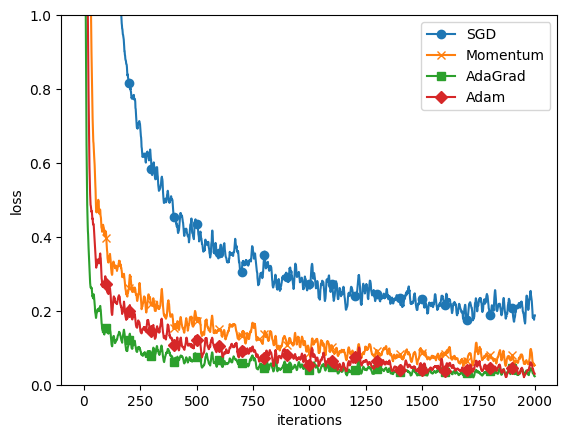

In [ ]:
# 6.1.8 MNIST 데이터셋으로 본 갱신 방법 비교

import numpy as np
import sys, os
sys.path.append('/content/drive/MyDrive/deep-learning-from-scratch/dataset') #구글 드라이브와 연결합니다.
from mnist import load_mnist #dataset.mnist가 아닌 그냥 mnist입니다!

import matplotlib.pyplot as plt


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)

        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)

    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

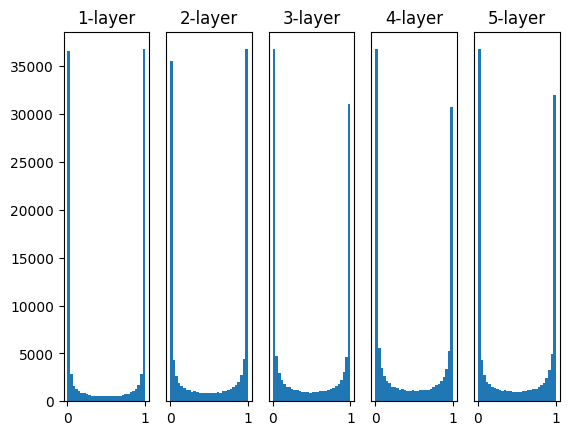

In [ ]:
# 6.2.2

# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)

input_data = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5  # 은닉층이 5개
activations = {}  # 이곳에 활성화 결과를 저장

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 초깃값을 다양하게 바꿔가며 실험해보자！
    w = np.random.randn(node_num, node_num) * 1
    # w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 활성화 함수도 바꿔가며 실험해보자！
    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

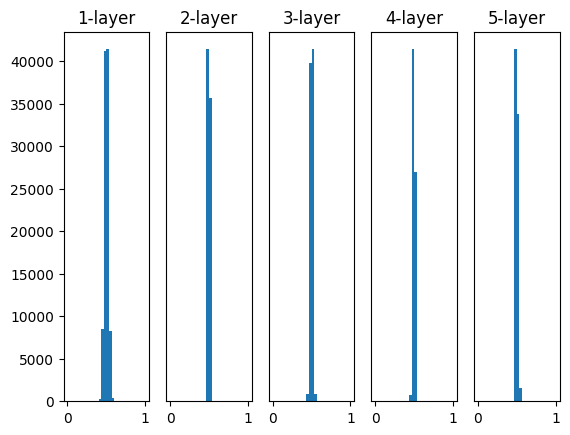

In [ ]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)

input_data = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5  # 은닉층이 5개
activations = {}  # 이곳에 활성화 결과를 저장

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 초깃값을 다양하게 바꿔가며 실험해보자！
    # w = np.random.randn(node_num, node_num) * 1
    w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 활성화 함수도 바꿔가며 실험해보자！
    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

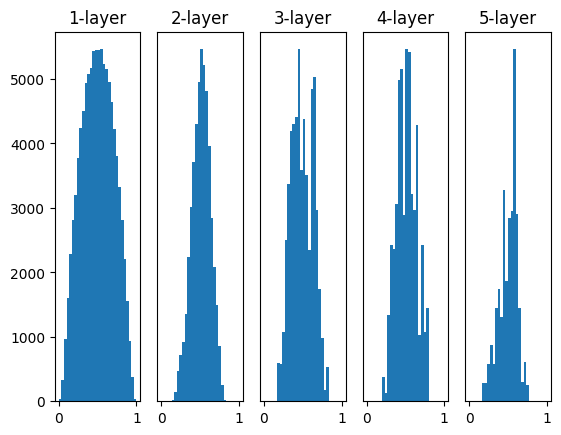

In [ ]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)

input_data = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5  # 은닉층이 5개
activations = {}  # 이곳에 활성화 결과를 저장

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 초깃값을 다양하게 바꿔가며 실험해보자！
    # w = np.random.randn(node_num, node_num) * 1
    # w = np.random.randn(node_num, node_num) * 0.01
    w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 활성화 함수도 바꿔가며 실험해보자！
    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

===========iteration:0===========
std=0.01:2.3025313195628807
Xavier:2.309994685490106
He:2.354752944951489
===========iteration:100===========
std=0.01:2.3025576804348344
Xavier:2.2349159883695444
He:1.4596649831731638
===========iteration:200===========
std=0.01:2.301629260089832
Xavier:2.0755508244052128
He:0.7264031390680128
===========iteration:300===========
std=0.01:2.301759246457607
Xavier:1.7982532996593
He:0.5191191598987456
===========iteration:400===========
std=0.01:2.302999039337731
Xavier:1.3277633686466161
He:0.47236595050706065
===========iteration:500===========
std=0.01:2.30046232996897
Xavier:0.8638606354505165
He:0.44730276004291825
===========iteration:600===========
std=0.01:2.299939217602986
Xavier:0.6333768709363548
He:0.3503281238097531
===========iteration:700===========
std=0.01:2.2965841518733585
Xavier:0.5153169000027473
He:0.3049151780828741
===========iteration:800===========
std=0.01:2.301768774060064
Xavier:0.4986700439618671
He:0.32146579160473265
===

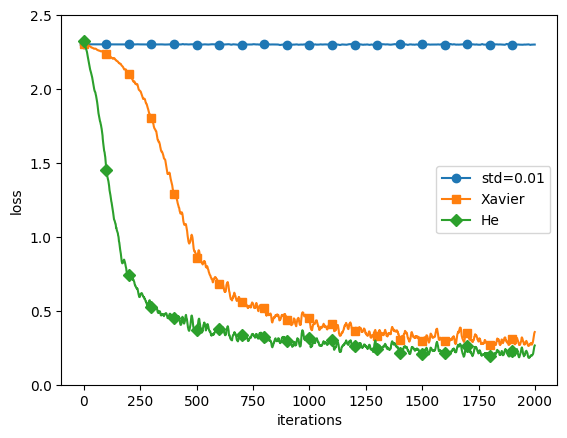

In [ ]:
# coding: utf-8

import numpy as np
import sys, os
sys.path.append('/content/drive/MyDrive/deep-learning-from-scratch/dataset') #구글 드라이브와 연결합니다.
from mnist import load_mnist #dataset.mnist가 아닌 그냥 mnist입니다!
import matplotlib.pyplot as plt


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)

        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)

    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

In [ ]:
class MultiLayerNetExtend:
    """완전 연결 다층 신경망(확장판)
    가중치 감소, 드롭아웃, 배치 정규화 구현

    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    weight_decay_lambda : 가중치 감소(L2 법칙)의 세기
    use_dropout : 드롭아웃 사용 여부
    dropout_ration : 드롭아웃 비율
    use_batchNorm : 배치 정규화 사용 여부
    """
    def __init__(self, input_size, hidden_size_list, output_size,
                 activation='relu', weight_init_std='relu', weight_decay_lambda=0,
                 use_dropout = False, dropout_ration = 0.5, use_batchnorm=False):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.use_dropout = use_dropout
        self.weight_decay_lambda = weight_decay_lambda
        self.use_batchnorm = use_batchnorm
        self.params = {}

        # 가중치 초기화
        self.__init_weight(weight_init_std)

        # 계층 생성
        activation_layer = {'sigmoid': Sigmoid, 'relu': Relu}
        self.layers = OrderedDict()
        for idx in range(1, self.hidden_layer_num+1):
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
                                                      self.params['b' + str(idx)])
            if self.use_batchnorm:
                self.params['gamma' + str(idx)] = np.ones(hidden_size_list[idx-1])
                self.params['beta' + str(idx)] = np.zeros(hidden_size_list[idx-1])
                self.layers['BatchNorm' + str(idx)] = BatchNormalization(self.params['gamma' + str(idx)], self.params['beta' + str(idx)])

            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()

            if self.use_dropout:
                self.layers['Dropout' + str(idx)] = Dropout(dropout_ration)

        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)], self.params['b' + str(idx)])

        self.last_layer = SoftmaxWithLoss()

    def __init_weight(self, weight_init_std):
        """가중치 초기화

        Parameters
        ----------
        weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
            'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
            'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
        """
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])  # ReLUを使う場合に推奨される初期値
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])  # sigmoidを使う場合に推奨される初期値
            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

    def predict(self, x, train_flg=False):
        for key, layer in self.layers.items():
            if "Dropout" in key or "BatchNorm" in key:
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)

        return x

    def loss(self, x, t, train_flg=False):
        """손실 함수를 구한다.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        """
        y = self.predict(x, train_flg)

        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)

        return self.last_layer.forward(y, t) + weight_decay

    def accuracy(self, X, T):
        Y = self.predict(X, train_flg=False)
        Y = np.argmax(Y, axis=1)
        if T.ndim != 1 : T = np.argmax(T, axis=1)

        accuracy = np.sum(Y == T) / float(X.shape[0])
        return accuracy

    def numerical_gradient(self, X, T):
        """기울기를 구한다(수치 미분).

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_W = lambda W: self.loss(X, T, train_flg=True)

        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = numerical_gradient(loss_W, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_W, self.params['b' + str(idx)])

            if self.use_batchnorm and idx != self.hidden_layer_num+1:
                grads['gamma' + str(idx)] = numerical_gradient(loss_W, self.params['gamma' + str(idx)])
                grads['beta' + str(idx)] = numerical_gradient(loss_W, self.params['beta' + str(idx)])

        return grads

    def gradient(self, x, t):
        # forward
        self.loss(x, t, train_flg=True)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + self.weight_decay_lambda * self.params['W' + str(idx)]
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db

            if self.use_batchnorm and idx != self.hidden_layer_num+1:
                grads['gamma' + str(idx)] = self.layers['BatchNorm' + str(idx)].dgamma
                grads['beta' + str(idx)] = self.layers['BatchNorm' + str(idx)].dbeta

        return grads

============== 1/16 ==============
epoch:0 | 0.097 - 0.136


<ipython-input-14-4bd93e01ab44>:96: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
<ipython-input-14-4bd93e01ab44>:96: RuntimeWarning: invalid value encountered in scalar multiply
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
<ipython-input-6-59f0eb11db12>:34: RuntimeWarning: invalid value encountered in subtract
  x = x - np.max(x, axis=0)


epoch:1 | 0.097 - 0.14
epoch:2 | 0.097 - 0.166
epoch:3 | 0.097 - 0.172
epoch:4 | 0.097 - 0.19
epoch:5 | 0.097 - 0.197
epoch:6 | 0.097 - 0.213
epoch:7 | 0.097 - 0.228
epoch:8 | 0.097 - 0.248
epoch:9 | 0.097 - 0.269
epoch:10 | 0.097 - 0.281
epoch:11 | 0.097 - 0.291
epoch:12 | 0.097 - 0.326
epoch:13 | 0.097 - 0.337
epoch:14 | 0.097 - 0.348
epoch:15 | 0.097 - 0.359
epoch:16 | 0.097 - 0.366
epoch:17 | 0.097 - 0.384
epoch:18 | 0.097 - 0.402
epoch:19 | 0.097 - 0.414


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


============== 2/16 ==============
epoch:0 | 0.116 - 0.063
epoch:1 | 0.097 - 0.097
epoch:2 | 0.097 - 0.117
epoch:3 | 0.097 - 0.15
epoch:4 | 0.097 - 0.174
epoch:5 | 0.097 - 0.202
epoch:6 | 0.097 - 0.239
epoch:7 | 0.097 - 0.254
epoch:8 | 0.097 - 0.269
epoch:9 | 0.097 - 0.295
epoch:10 | 0.097 - 0.317
epoch:11 | 0.097 - 0.344
epoch:12 | 0.097 - 0.368
epoch:13 | 0.097 - 0.377
epoch:14 | 0.097 - 0.4
epoch:15 | 0.097 - 0.416
epoch:16 | 0.097 - 0.438
epoch:17 | 0.097 - 0.46
epoch:18 | 0.097 - 0.472


epoch:19 | 0.097 - 0.489
============== 3/16 ==============
epoch:0 | 0.12 - 0.127
epoch:1 | 0.351 - 0.148
epoch:2 | 0.481 - 0.175
epoch:3 | 0.594 - 0.229
epoch:4 | 0.658 - 0.264
epoch:5 | 0.713 - 0.296
epoch:6 | 0.754 - 0.329
epoch:7 | 0.807 - 0.367
epoch:8 | 0.838 - 0.393
epoch:9 | 0.866 - 0.423
epoch:10 | 0.875 - 0.446
epoch:11 | 0.898 - 0.475
epoch:12 | 0.916 - 0.508
epoch:13 | 0.925 - 0.533
epoch:14 | 0.945 - 0.553
epoch:15 | 0.951 - 0.573
epoch:16 | 0.965 - 0.589
epoch:17 | 0.965 - 0.605
epoch:18 | 0.971 - 0.61


epoch:19 | 0.975 - 0.626
============== 4/16 ==============
epoch:0 | 0.088 - 0.094
epoch:1 | 0.164 - 0.105
epoch:2 | 0.301 - 0.191
epoch:3 | 0.41 - 0.284
epoch:4 | 0.479 - 0.353
epoch:5 | 0.572 - 0.433
epoch:6 | 0.621 - 0.505
epoch:7 | 0.671 - 0.546
epoch:8 | 0.689 - 0.593
epoch:9 | 0.731 - 0.62
epoch:10 | 0.759 - 0.66
epoch:11 | 0.764 - 0.675
epoch:12 | 0.783 - 0.693
epoch:13 | 0.793 - 0.709
epoch:14 | 0.821 - 0.722
epoch:15 | 0.829 - 0.731
epoch:16 | 0.84 - 0.748
epoch:17 | 0.85 - 0.767
epoch:18 | 0.854 - 0.773


epoch:19 | 0.857 - 0.786
============== 5/16 ==============
epoch:0 | 0.056 - 0.066
epoch:1 | 0.053 - 0.128
epoch:2 | 0.059 - 0.279
epoch:3 | 0.063 - 0.434
epoch:4 | 0.068 - 0.526
epoch:5 | 0.076 - 0.601
epoch:6 | 0.079 - 0.672
epoch:7 | 0.088 - 0.708
epoch:8 | 0.093 - 0.735
epoch:9 | 0.1 - 0.767
epoch:10 | 0.12 - 0.787
epoch:11 | 0.128 - 0.8
epoch:12 | 0.144 - 0.809
epoch:13 | 0.14 - 0.824
epoch:14 | 0.138 - 0.837
epoch:15 | 0.126 - 0.844
epoch:16 | 0.131 - 0.86
epoch:17 | 0.139 - 0.868
epoch:18 | 0.148 - 0.879


epoch:19 | 0.142 - 0.881
============== 6/16 ==============
epoch:0 | 0.098 - 0.094
epoch:1 | 0.104 - 0.19
epoch:2 | 0.088 - 0.435
epoch:3 | 0.108 - 0.576
epoch:4 | 0.117 - 0.638
epoch:5 | 0.13 - 0.712
epoch:6 | 0.13 - 0.75
epoch:7 | 0.149 - 0.788
epoch:8 | 0.127 - 0.805
epoch:9 | 0.118 - 0.819
epoch:10 | 0.119 - 0.833
epoch:11 | 0.119 - 0.854
epoch:12 | 0.117 - 0.863
epoch:13 | 0.116 - 0.89
epoch:14 | 0.116 - 0.904
epoch:15 | 0.116 - 0.919
epoch:16 | 0.116 - 0.93
epoch:17 | 0.116 - 0.941
epoch:18 | 0.116 - 0.946


epoch:19 | 0.116 - 0.948
============== 7/16 ==============
epoch:0 | 0.105 - 0.116
epoch:1 | 0.116 - 0.286
epoch:2 | 0.116 - 0.586
epoch:3 | 0.116 - 0.72
epoch:4 | 0.116 - 0.792
epoch:5 | 0.116 - 0.842
epoch:6 | 0.116 - 0.863
epoch:7 | 0.116 - 0.891
epoch:8 | 0.116 - 0.902
epoch:9 | 0.116 - 0.924
epoch:10 | 0.116 - 0.934
epoch:11 | 0.116 - 0.948
epoch:12 | 0.116 - 0.958
epoch:13 | 0.116 - 0.964
epoch:14 | 0.116 - 0.966
epoch:15 | 0.116 - 0.979
epoch:16 | 0.116 - 0.981
epoch:17 | 0.116 - 0.985
epoch:18 | 0.116 - 0.988


epoch:19 | 0.117 - 0.99
============== 8/16 ==============
epoch:0 | 0.117 - 0.098
epoch:1 | 0.117 - 0.348
epoch:2 | 0.117 - 0.64
epoch:3 | 0.117 - 0.743
epoch:4 | 0.117 - 0.798
epoch:5 | 0.117 - 0.851
epoch:6 | 0.117 - 0.905
epoch:7 | 0.117 - 0.924
epoch:8 | 0.117 - 0.955
epoch:9 | 0.117 - 0.964
epoch:10 | 0.117 - 0.966
epoch:11 | 0.117 - 0.977
epoch:12 | 0.117 - 0.983
epoch:13 | 0.117 - 0.984
epoch:14 | 0.117 - 0.987
epoch:15 | 0.117 - 0.989
epoch:16 | 0.117 - 0.99
epoch:17 | 0.117 - 0.992
epoch:18 | 0.116 - 0.995


epoch:19 | 0.116 - 0.994
============== 9/16 ==============
epoch:0 | 0.116 - 0.097
epoch:1 | 0.105 - 0.539
epoch:2 | 0.116 - 0.68
epoch:3 | 0.116 - 0.757
epoch:4 | 0.116 - 0.83
epoch:5 | 0.116 - 0.853
epoch:6 | 0.116 - 0.925
epoch:7 | 0.116 - 0.935
epoch:8 | 0.116 - 0.977
epoch:9 | 0.116 - 0.981
epoch:10 | 0.116 - 0.988
epoch:11 | 0.116 - 0.992
epoch:12 | 0.116 - 0.995
epoch:13 | 0.116 - 0.996
epoch:14 | 0.116 - 0.998
epoch:15 | 0.116 - 0.985
epoch:16 | 0.116 - 0.99
epoch:17 | 0.116 - 0.998
epoch:18 | 0.116 - 0.997


epoch:19 | 0.116 - 0.996
============== 10/16 ==============
epoch:0 | 0.093 - 0.148
epoch:1 | 0.116 - 0.571
epoch:2 | 0.116 - 0.71
epoch:3 | 0.117 - 0.734
epoch:4 | 0.117 - 0.842
epoch:5 | 0.117 - 0.82
epoch:6 | 0.117 - 0.908
epoch:7 | 0.117 - 0.971
epoch:8 | 0.117 - 0.926
epoch:9 | 0.117 - 0.981
epoch:10 | 0.117 - 0.989
epoch:11 | 0.117 - 0.992
epoch:12 | 0.117 - 0.993
epoch:13 | 0.117 - 0.994
epoch:14 | 0.117 - 0.994
epoch:15 | 0.117 - 0.998
epoch:16 | 0.117 - 0.998
epoch:17 | 0.117 - 0.999
epoch:18 | 0.117 - 0.999


epoch:19 | 0.117 - 0.999
============== 11/16 ==============
epoch:0 | 0.105 - 0.134
epoch:1 | 0.117 - 0.698
epoch:2 | 0.117 - 0.712
epoch:3 | 0.117 - 0.806
epoch:4 | 0.116 - 0.853
epoch:5 | 0.116 - 0.796
epoch:6 | 0.117 - 0.875
epoch:7 | 0.117 - 0.885
epoch:8 | 0.117 - 0.879
epoch:9 | 0.117 - 0.548
epoch:10 | 0.117 - 0.89
epoch:11 | 0.117 - 0.981
epoch:12 | 0.117 - 0.982
epoch:13 | 0.117 - 0.979
epoch:14 | 0.117 - 0.989
epoch:15 | 0.116 - 0.958
epoch:16 | 0.117 - 0.991
epoch:17 | 0.117 - 0.989
epoch:18 | 0.117 - 0.994


epoch:19 | 0.117 - 0.995
============== 12/16 ==============
epoch:0 | 0.099 - 0.101
epoch:1 | 0.117 - 0.451
epoch:2 | 0.117 - 0.647
epoch:3 | 0.117 - 0.656
epoch:4 | 0.117 - 0.692
epoch:5 | 0.116 - 0.675
epoch:6 | 0.116 - 0.685
epoch:7 | 0.116 - 0.701
epoch:8 | 0.116 - 0.639
epoch:9 | 0.117 - 0.711
epoch:10 | 0.116 - 0.745
epoch:11 | 0.116 - 0.767
epoch:12 | 0.116 - 0.775
epoch:13 | 0.116 - 0.794
epoch:14 | 0.116 - 0.78
epoch:15 | 0.116 - 0.798
epoch:16 | 0.117 - 0.804
epoch:17 | 0.117 - 0.809
epoch:18 | 0.117 - 0.811


epoch:19 | 0.117 - 0.811
============== 13/16 ==============
epoch:0 | 0.117 - 0.118
epoch:1 | 0.116 - 0.432
epoch:2 | 0.117 - 0.571
epoch:3 | 0.117 - 0.599
epoch:4 | 0.117 - 0.696
epoch:5 | 0.116 - 0.695
epoch:6 | 0.116 - 0.729
epoch:7 | 0.116 - 0.734
epoch:8 | 0.116 - 0.762
epoch:9 | 0.117 - 0.764
epoch:10 | 0.117 - 0.783
epoch:11 | 0.117 - 0.783
epoch:12 | 0.117 - 0.749
epoch:13 | 0.117 - 0.755
epoch:14 | 0.117 - 0.788
epoch:15 | 0.117 - 0.796
epoch:16 | 0.117 - 0.796
epoch:17 | 0.117 - 0.797
epoch:18 | 0.117 - 0.8


epoch:19 | 0.117 - 0.802
============== 14/16 ==============
epoch:0 | 0.117 - 0.23
epoch:1 | 0.116 - 0.405
epoch:2 | 0.116 - 0.38
epoch:3 | 0.116 - 0.455
epoch:4 | 0.116 - 0.488
epoch:5 | 0.116 - 0.487
epoch:6 | 0.117 - 0.496
epoch:7 | 0.117 - 0.515
epoch:8 | 0.117 - 0.46
epoch:9 | 0.117 - 0.51
epoch:10 | 0.117 - 0.524
epoch:11 | 0.117 - 0.523
epoch:12 | 0.117 - 0.522
epoch:13 | 0.117 - 0.522
epoch:14 | 0.117 - 0.518
epoch:15 | 0.117 - 0.523
epoch:16 | 0.117 - 0.588
epoch:17 | 0.117 - 0.614
epoch:18 | 0.117 - 0.521


epoch:19 | 0.117 - 0.616
============== 15/16 ==============
epoch:0 | 0.105 - 0.106
epoch:1 | 0.117 - 0.394
epoch:2 | 0.116 - 0.293
epoch:3 | 0.117 - 0.411
epoch:4 | 0.117 - 0.413
epoch:5 | 0.117 - 0.418
epoch:6 | 0.117 - 0.441
epoch:7 | 0.117 - 0.431
epoch:8 | 0.117 - 0.421
epoch:9 | 0.117 - 0.428
epoch:10 | 0.117 - 0.499
epoch:11 | 0.117 - 0.513
epoch:12 | 0.117 - 0.513
epoch:13 | 0.117 - 0.514
epoch:14 | 0.117 - 0.521
epoch:15 | 0.117 - 0.526
epoch:16 | 0.117 - 0.527
epoch:17 | 0.117 - 0.523
epoch:18 | 0.117 - 0.549


epoch:19 | 0.117 - 0.568
============== 16/16 ==============
epoch:0 | 0.116 - 0.197
epoch:1 | 0.116 - 0.125
epoch:2 | 0.116 - 0.301
epoch:3 | 0.116 - 0.302
epoch:4 | 0.117 - 0.304
epoch:5 | 0.116 - 0.304
epoch:6 | 0.117 - 0.304
epoch:7 | 0.117 - 0.387
epoch:8 | 0.116 - 0.395
epoch:9 | 0.116 - 0.416
epoch:10 | 0.116 - 0.419
epoch:11 | 0.117 - 0.419
epoch:12 | 0.117 - 0.365
epoch:13 | 0.117 - 0.419
epoch:14 | 0.117 - 0.413
epoch:15 | 0.117 - 0.423
epoch:16 | 0.117 - 0.423
epoch:17 | 0.117 - 0.423
epoch:18 | 0.117 - 0.421
epoch:19 | 0.117 - 0.423


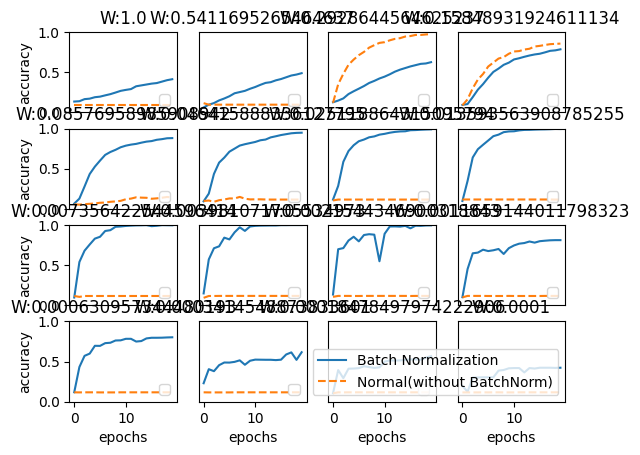

In [ ]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 학습 데이터를 줄임
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)

    train_acc_list = []
    bn_train_acc_list = []

    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0

    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]

        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)

        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)

            print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))

            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break

    return train_acc_list, bn_train_acc_list


# 그래프 그리기==========
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)

    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')

plt.show()

epoch:0, train acc:0.14333333333333334, test acc:0.118
epoch:1, train acc:0.16666666666666666, test acc:0.1283
epoch:2, train acc:0.18666666666666668, test acc:0.1429
epoch:3, train acc:0.2, test acc:0.1616
epoch:4, train acc:0.22666666666666666, test acc:0.1866
epoch:5, train acc:0.2633333333333333, test acc:0.2028
epoch:6, train acc:0.30333333333333334, test acc:0.2184
epoch:7, train acc:0.32666666666666666, test acc:0.2385
epoch:8, train acc:0.35, test acc:0.2572
epoch:9, train acc:0.38333333333333336, test acc:0.2748
epoch:10, train acc:0.41333333333333333, test acc:0.2887
epoch:11, train acc:0.45, test acc:0.3069
epoch:12, train acc:0.5, test acc:0.3274
epoch:13, train acc:0.5166666666666667, test acc:0.3425
epoch:14, train acc:0.54, test acc:0.3671
epoch:15, train acc:0.5633333333333334, test acc:0.3883
epoch:16, train acc:0.5833333333333334, test acc:0.4072
epoch:17, train acc:0.6033333333333334, test acc:0.4127
epoch:18, train acc:0.6033333333333334, test acc:0.4218
epoch:19, t

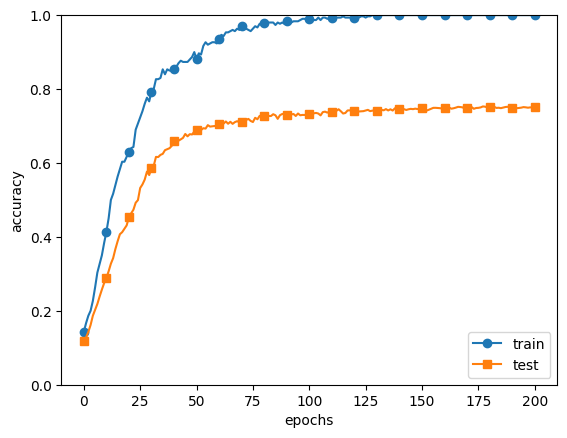

In [ ]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（가중치 감쇠） 설정 =======================
weight_decay_lambda = 0 # weight decay를 사용하지 않을 경우
# weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01) # 학습률이 0.01인 SGD로 매개변수 갱신

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

epoch:0, train acc:0.13666666666666666, test acc:0.1295
epoch:1, train acc:0.16666666666666666, test acc:0.1455
epoch:2, train acc:0.18666666666666668, test acc:0.1585
epoch:3, train acc:0.22666666666666666, test acc:0.1778
epoch:4, train acc:0.27, test acc:0.2044
epoch:5, train acc:0.3233333333333333, test acc:0.2327
epoch:6, train acc:0.3333333333333333, test acc:0.2486
epoch:7, train acc:0.38, test acc:0.2637
epoch:8, train acc:0.37333333333333335, test acc:0.2718
epoch:9, train acc:0.37666666666666665, test acc:0.2858
epoch:10, train acc:0.39666666666666667, test acc:0.3074
epoch:11, train acc:0.41333333333333333, test acc:0.3197
epoch:12, train acc:0.42, test acc:0.3212
epoch:13, train acc:0.4633333333333333, test acc:0.3462
epoch:14, train acc:0.4766666666666667, test acc:0.35
epoch:15, train acc:0.45666666666666667, test acc:0.3509
epoch:16, train acc:0.4766666666666667, test acc:0.3608
epoch:17, train acc:0.46, test acc:0.3661
epoch:18, train acc:0.4766666666666667, test acc:0.

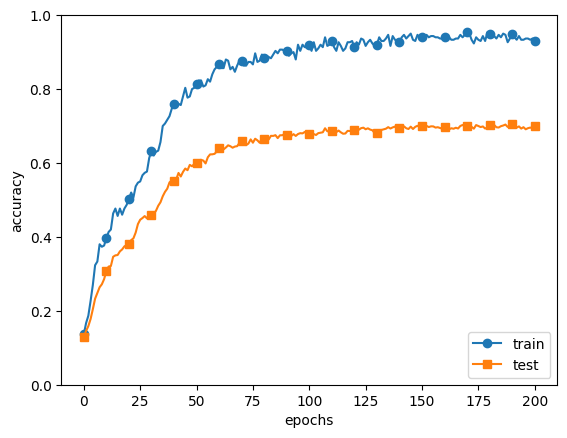

In [ ]:
# 오버피팅

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（가중치 감쇠） 설정 =======================
#weight_decay_lambda = 0 # weight decay를 사용하지 않을 경우
weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01) # 학습률이 0.01인 SGD로 매개변수 갱신

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

In [ ]:
class Trainer:
    """신경망 훈련을 대신 해주는 클래스
    """
    def __init__(self, network, x_train, t_train, x_test, t_test,
                 epochs=20, mini_batch_size=100,
                 optimizer='SGD', optimizer_param={'lr':0.01},
                 evaluate_sample_num_per_epoch=None, verbose=True):
        self.network = network
        self.verbose = verbose
        self.x_train = x_train
        self.t_train = t_train
        self.x_test = x_test
        self.t_test = t_test
        self.epochs = epochs
        self.batch_size = mini_batch_size
        self.evaluate_sample_num_per_epoch = evaluate_sample_num_per_epoch

        # optimzer
        optimizer_class_dict = {'sgd':SGD, 'momentum':Momentum, 'nesterov':Nesterov,
                                'adagrad':AdaGrad, 'rmsprpo':RMSprop, 'adam':Adam}
        self.optimizer = optimizer_class_dict[optimizer.lower()](**optimizer_param)

        self.train_size = x_train.shape[0]
        self.iter_per_epoch = max(self.train_size / mini_batch_size, 1)
        self.max_iter = int(epochs * self.iter_per_epoch)
        self.current_iter = 0
        self.current_epoch = 0

        self.train_loss_list = []
        self.train_acc_list = []
        self.test_acc_list = []

    def train_step(self):
        batch_mask = np.random.choice(self.train_size, self.batch_size)
        x_batch = self.x_train[batch_mask]
        t_batch = self.t_train[batch_mask]

        grads = self.network.gradient(x_batch, t_batch)
        self.optimizer.update(self.network.params, grads)

        loss = self.network.loss(x_batch, t_batch)
        self.train_loss_list.append(loss)
        if self.verbose: print("train loss:" + str(loss))

        if self.current_iter % self.iter_per_epoch == 0:
            self.current_epoch += 1

            x_train_sample, t_train_sample = self.x_train, self.t_train
            x_test_sample, t_test_sample = self.x_test, self.t_test
            if not self.evaluate_sample_num_per_epoch is None:
                t = self.evaluate_sample_num_per_epoch
                x_train_sample, t_train_sample = self.x_train[:t], self.t_train[:t]
                x_test_sample, t_test_sample = self.x_test[:t], self.t_test[:t]

            train_acc = self.network.accuracy(x_train_sample, t_train_sample)
            test_acc = self.network.accuracy(x_test_sample, t_test_sample)
            self.train_acc_list.append(train_acc)
            self.test_acc_list.append(test_acc)

            if self.verbose: print("=== epoch:" + str(self.current_epoch) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc) + " ===")
        self.current_iter += 1

    def train(self):
        for i in range(self.max_iter):
            self.train_step()

        test_acc = self.network.accuracy(self.x_test, self.t_test)

        if self.verbose:
            print("=============== Final Test Accuracy ===============")
            print("test acc:" + str(test_acc))


train loss:2.2983642918971707
=== epoch:1, train acc:0.18666666666666668, test acc:0.1762 ===
train loss:2.318809013124153
train loss:2.2907919512114727
train loss:2.2923747140609776
=== epoch:2, train acc:0.19333333333333333, test acc:0.1809 ===
train loss:2.3044777715341236
train loss:2.3172895979453747
train loss:2.321444653409202
=== epoch:3, train acc:0.19333333333333333, test acc:0.1823 ===
train loss:2.3007217718648914
train loss:2.2863876662683613
train loss:2.320585888101338
=== epoch:4, train acc:0.19333333333333333, test acc:0.1843 ===
train loss:2.3076517161212746
train loss:2.30584434961318
train loss:2.304966082421684
=== epoch:5, train acc:0.19666666666666666, test acc:0.1876 ===
train loss:2.285202072185007
train loss:2.2977752252801418
train loss:2.2938773235632457
=== epoch:6, train acc:0.2, test acc:0.1898 ===
train loss:2.306849375238998
train loss:2.303806933846232
train loss:2.2864026710489687
=== epoch:7, train acc:0.2, test acc:0.1909 ===
train loss:2.2837518394

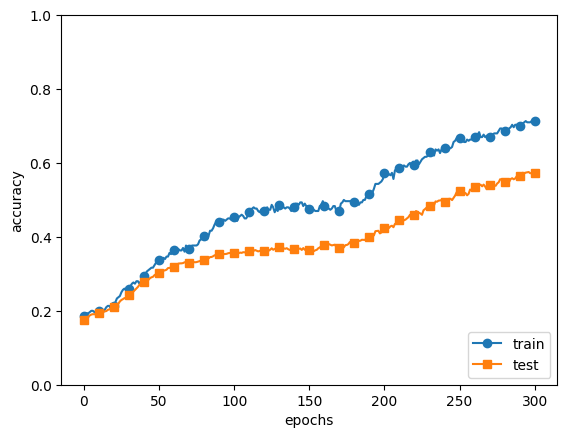

In [ ]:
# 드롭아웃

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# 드롭아웃 사용 유무와 비율 설정 ========================
use_dropout = True  # 드롭아웃을 쓰지 않을 때는 False
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

val acc:0.76 | lr:0.006444375978603898, weight decay:9.393689480947798e-05
val acc:0.07 | lr:7.791511089943457e-06, weight decay:7.416962912110578e-07
val acc:0.07 | lr:5.256182777066498e-05, weight decay:3.999339959685284e-06
val acc:0.03 | lr:2.674584855918272e-06, weight decay:6.115839431804704e-08
val acc:0.28 | lr:0.0011713134821463918, weight decay:4.933921067634766e-05
val acc:0.79 | lr:0.0044694882552975355, weight decay:1.9450828871688705e-08
val acc:0.07 | lr:7.228674370779094e-05, weight decay:1.3834706638590758e-06
val acc:0.08 | lr:2.998006247992599e-06, weight decay:5.89915145234878e-07
val acc:0.08 | lr:0.0001063419486234513, weight decay:1.017627200655059e-06
val acc:0.09 | lr:1.2744113492485241e-06, weight decay:4.01606871548537e-05
val acc:0.11 | lr:4.1882004159491685e-06, weight decay:3.3749229222085844e-06
val acc:0.71 | lr:0.0054527463321282395, weight decay:6.344239599505924e-08
val acc:0.14 | lr:0.0001570288893943787, weight decay:8.586232589190314e-07
val acc:0.

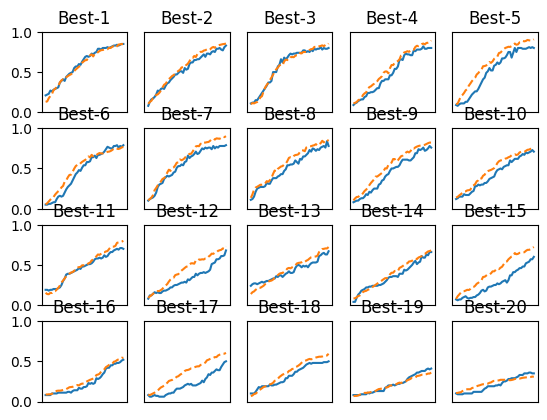

In [ ]:
# 하이퍼파라미터 최적화

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 결과를 빠르게 얻기 위해 훈련 데이터를 줄임
x_train = x_train[:500]
t_train = t_train[:500]

# 20%를 검증 데이터로 분할
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# 하이퍼파라미터 무작위 탐색======================================
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 탐색한 하이퍼파라미터의 범위 지정===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

# 그래프 그리기========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()